In [ ]:
!unzip netflix-report.zip

Archive:  netflix-report.zip
   creating: netflix-report/
   creating: netflix-report/MESSAGES/
  inflating: netflix-report/MESSAGES/MessagesSentByNetflix.csv  
   creating: __MACOSX/
   creating: __MACOSX/netflix-report/
   creating: __MACOSX/netflix-report/MESSAGES/
  inflating: __MACOSX/netflix-report/MESSAGES/._MessagesSentByNetflix.csv  
  inflating: __MACOSX/netflix-report/._MESSAGES  
   creating: netflix-report/CONTENT_INTERACTION/
  inflating: netflix-report/CONTENT_INTERACTION/IndicatedPreferences.csv  
   creating: __MACOSX/netflix-report/CONTENT_INTERACTION/
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._IndicatedPreferences.csv  
  inflating: netflix-report/CONTENT_INTERACTION/.DS_Store  
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._.DS_Store  
  inflating: netflix-report/CONTENT_INTERACTION/MyList.csv  
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._MyList.csv  
  inflating: netflix-report/CONTENT_INTERACTION/Ratings.csv  
  inflating

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
devices_df = pd.read_csv('netflix-report/ACCOUNT/AccessAndDevices.csv')
clickstream_df = pd.read_csv('netflix-report/CLICKSTREAM/Clickstream.csv')
viewing_df = pd.read_csv('netflix-report/CONTENT_INTERACTION/ViewingActivity.csv', on_bad_lines='skip')
profiles_df = pd.read_csv('netflix-report/PROFILES/Profiles.csv')
device_meta_df = pd.read_csv('netflix-report/DEVICES/Devices.csv')

In [ ]:
viewing_df = viewing_df[['Profile Name', 'Start Time', 'Duration', 'Device Type', 'Title']]
clickstream_df = clickstream_df[['Profile Name', 'Click Utc Ts', 'Webpage Url']]

viewing_df['Start Time'] = pd.to_datetime(viewing_df['Start Time'])
clickstream_df['Click Utc Ts'] = pd.to_datetime(clickstream_df['Click Utc Ts'])

devices_df['Date'] = pd.to_datetime(devices_df['Date'])

<ipython-input-4-e28c412732c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clickstream_df['Click Utc Ts'] = pd.to_datetime(clickstream_df['Click Utc Ts'])


In [ ]:
merged = viewing_df.merge(profiles_df[['Profile Name', 'Date Of Birth']], on='Profile Name', how='left')

merged = merged.merge(device_meta_df[['Profile Name', 'Device Type', 'Profile First Playback Date']],
                      on=['Profile Name', 'Device Type'], how='left')

clickstream_df = clickstream_df.sort_values(['Profile Name', 'Click Utc Ts'])
merged = merged.sort_values(['Profile Name', 'Start Time'])

In [ ]:
merged['hour'] = merged['Start Time'].dt.hour
merged['day_of_week'] = merged['Start Time'].dt.day_name()
merged['month'] = merged['Start Time'].dt.month_name()
merged['is_weekend'] = merged['day_of_week'].isin(['Saturday', 'Sunday'])

In [ ]:
def to_seconds(x):
    try:
        h, m, s = x.split(':')
        return int(h)*3600 + int(m)*60 + int(s)
    except:
        return np.nan

merged['duration_sec'] = merged['Duration'].astype(str).apply(to_seconds)

merged = merged.dropna(subset=['Start Time', 'Duration', 'duration_sec'])

In [ ]:
hourly = merged.groupby('hour')['duration_sec'].sum().reset_index()

user_hourly = merged.groupby(['Profile Name', 'hour'])['duration_sec'].sum().reset_index()

device_hourly = merged.groupby(['Device Type', 'hour'])['duration_sec'].sum().reset_index()

weekagg = merged.groupby('is_weekend')['duration_sec'].agg(['sum','mean','count']).reset_index()

monthly = merged.groupby('month')['duration_sec'].sum().reindex(
    ['January','February','March','April','May','June','July','August','September','October','November','December']
).dropna().reset_index()

profile_device = merged.groupby(['Profile Name','Device Type'])['duration_sec'].sum().reset_index()

user_totals = merged.groupby('Profile Name')['duration_sec'].sum().reset_index()

device_totals = merged.groupby('Device Type')['duration_sec'].sum().reset_index()

user_week_part = merged.groupby(['Profile Name', 'is_weekend'])['duration_sec'].mean().reset_index()

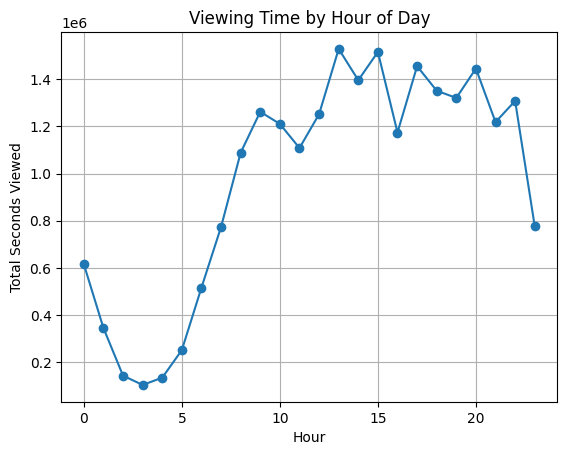

In [ ]:
plt.figure()
plt.plot(hourly['hour'], hourly['duration_sec'], marker='o')
plt.title('Viewing Time by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Seconds Viewed')
plt.grid(True)
plt.show()

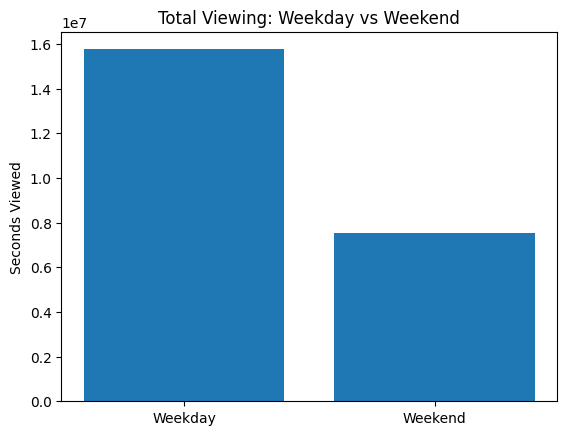

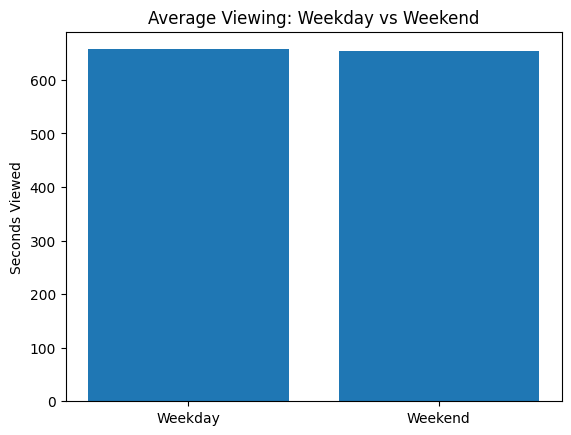

In [ ]:
plt.figure()
plt.bar(['Weekday','Weekend'], weekagg['sum'])
plt.title('Total Viewing: Weekday vs Weekend')
plt.ylabel('Seconds Viewed')
plt.show()

plt.figure()
plt.bar(['Weekday','Weekend'], weekagg['mean'])
plt.title('Average Viewing: Weekday vs Weekend')
plt.ylabel('Seconds Viewed')
plt.show()

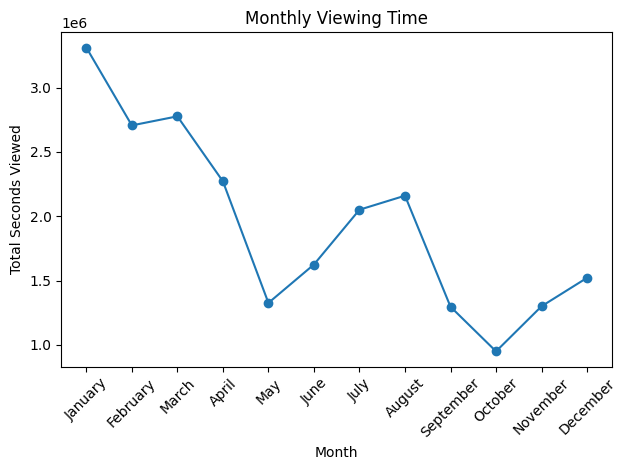

In [ ]:
plt.figure()
plt.plot(monthly['month'], monthly['duration_sec'], marker='o')
plt.title('Monthly Viewing Time')
plt.xlabel('Month')
plt.ylabel('Total Seconds Viewed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

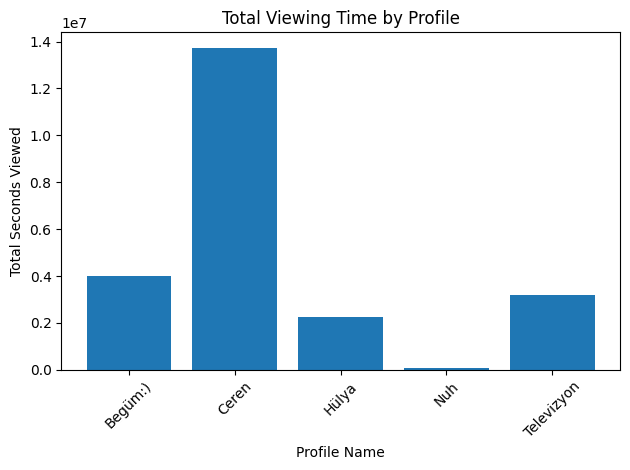

In [ ]:
plt.figure()
plt.bar(
    user_totals['Profile Name'],
    user_totals['duration_sec']
)
plt.title('Total Viewing Time by Profile')
plt.xlabel('Profile Name')
plt.ylabel('Total Seconds Viewed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

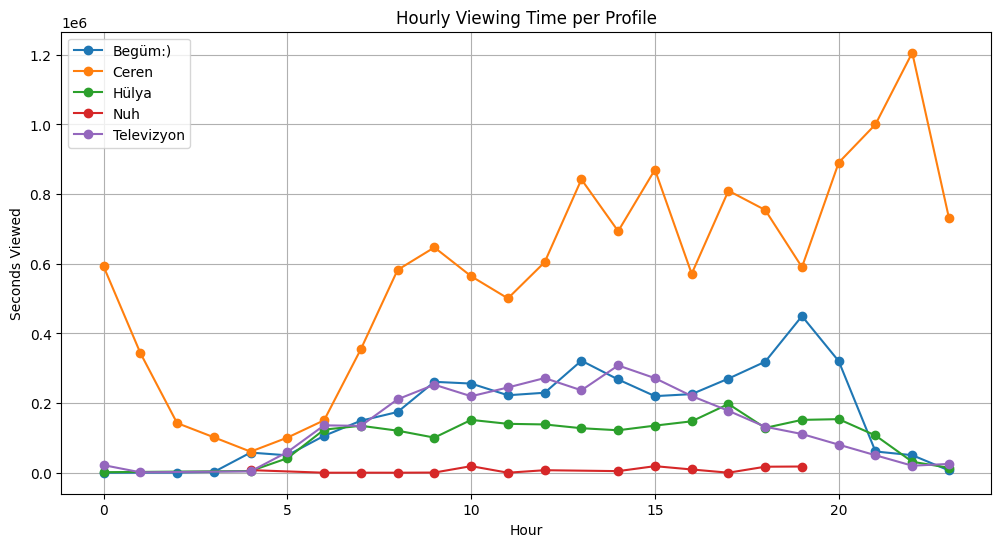

In [ ]:
plt.figure(figsize=(12,6))
for name, grp in user_hourly.groupby('Profile Name'):
    plt.plot(grp['hour'], grp['duration_sec'], marker='o', label=name)
plt.title('Hourly Viewing Time per Profile')
plt.xlabel('Hour')
plt.ylabel('Seconds Viewed')
plt.legend()
plt.grid(True)
plt.show()

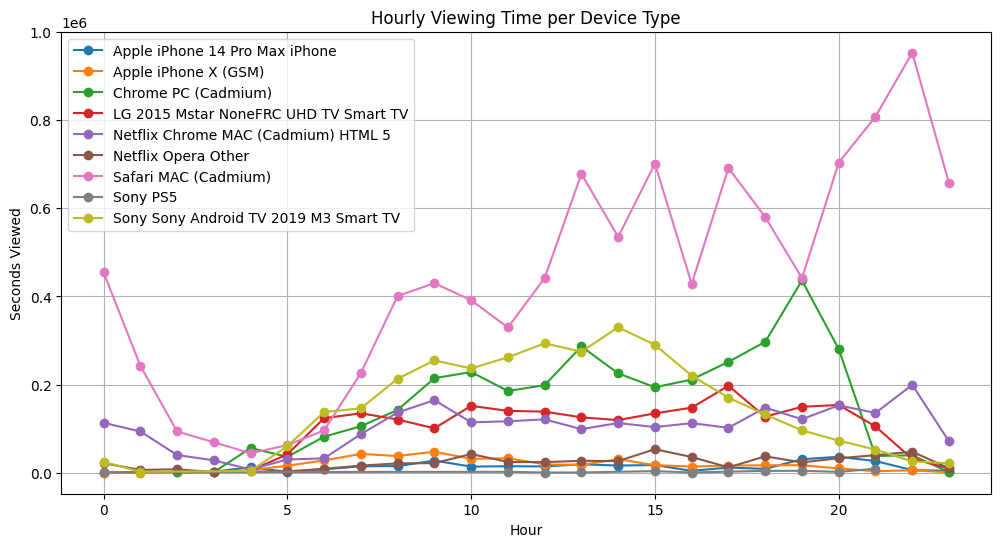

In [ ]:
plt.figure(figsize=(12,6))
for dev, grp in device_hourly.groupby('Device Type'):
    plt.plot(grp['hour'], grp['duration_sec'], marker='o', label=dev)
plt.title('Hourly Viewing Time per Device Type')
plt.xlabel('Hour')
plt.ylabel('Seconds Viewed')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import ttest_rel

pivoted = user_week_part.pivot(index='Profile Name', columns='is_weekend', values='duration_sec')

pivoted.columns = ['weekday_hours', 'weekend_hours']

pivoted = pivoted.dropna()

pivoted = pivoted / 3600

weekday_hours = pivoted['weekday_hours'].tolist()
weekend_hours = pivoted['weekend_hours'].tolist()

t_stat, p_value_two_sided = ttest_rel(weekend_hours, weekday_hours)

if t_stat > 0:
    p_value = p_value_two_sided / 2
else:
    p_value = 1 - (p_value_two_sided / 2)

print("p-value:", p_value)


p-value: 0.1855004730620539


In [ ]:
winter_months = ['December', 'January', 'February']
summer_months = ['June', 'July', 'August']

merged['season'] = merged['month'].apply(
    lambda x: 'winter' if x in winter_months else ('summer' if x in summer_months else 'other')
)

user_season = merged[merged['season'].isin(['winter', 'summer'])].groupby(
    ['Profile Name', 'season']
)['duration_sec'].mean().reset_index()

pivoted = user_season.pivot(index='Profile Name', columns='season', values='duration_sec')
pivoted = pivoted.dropna()
pivoted = pivoted / 3600

from scipy.stats import ttest_rel
import numpy as np

winter_hours = pivoted['winter'].tolist()
summer_hours = pivoted['summer'].tolist()

t_stat, p_val_two_sided = ttest_rel(winter_hours, summer_hours)

# One-sided test: you expect winter > summer
if t_stat > 0:
    p_value = p_val_two_sided / 2
else:
    p_value = 1 - (p_val_two_sided / 2)

print("p-value:", p_value)

p-value: 0.1605176240455351


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

features = ['hour',
            'day_of_week',
            'Device Type',
            'Profile Name',
            'is_weekend']
X = merged[features].copy()
y = merged['duration_sec']

cat_cols = ['day_of_week', 'Device Type', 'Profile Name']
num_cols = ['hour', 'is_weekend']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

gbr = GradientBoostingRegressor(random_state=42)

pipe = Pipeline(steps=[('prep', preprocess),
                       ('model', gbr)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(f"MAE  : {mean_absolute_error(y_test, pred):.1f} sec")

rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"RMSE : {rmse:.1f} sec")

print(f"R²   : {r2_score(y_test, pred):.3f}")


MAE  : 594.0 sec
RMSE : 871.9 sec
R²   : 0.010


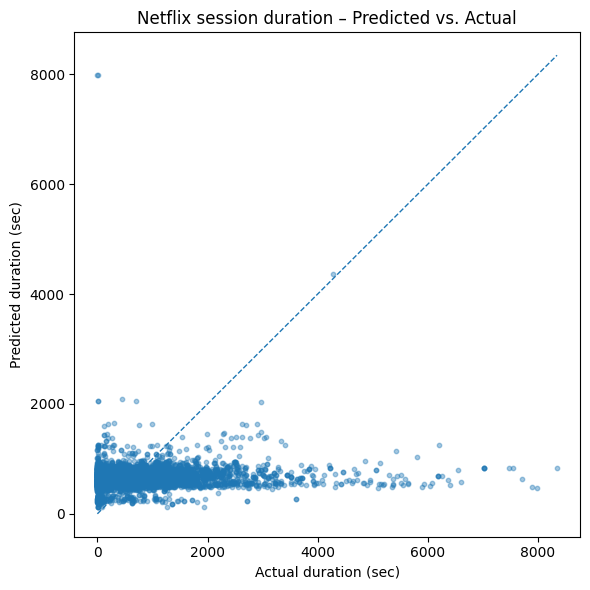

In [ ]:
import matplotlib.pyplot as plt

actual    = y_test
predicted = pred

plt.figure(figsize=(6, 6))
plt.scatter(actual, predicted, alpha=0.4, s=10)
lim = max(actual.max(), predicted.max())
plt.plot([0, lim], [0, lim], linestyle='--', linewidth=1)

plt.xlabel("Actual duration (sec)")
plt.ylabel("Predicted duration (sec)")
plt.title("Netflix session duration – Predicted vs. Actual")
plt.tight_layout()
plt.show()


MAE  : 21303.6 sec
RMSE : 37047.6 sec
R²   : 0.011


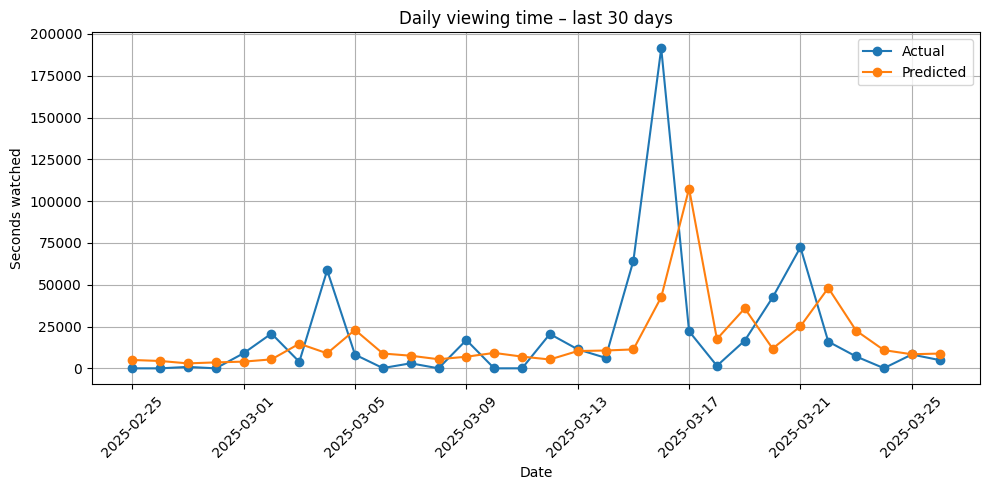

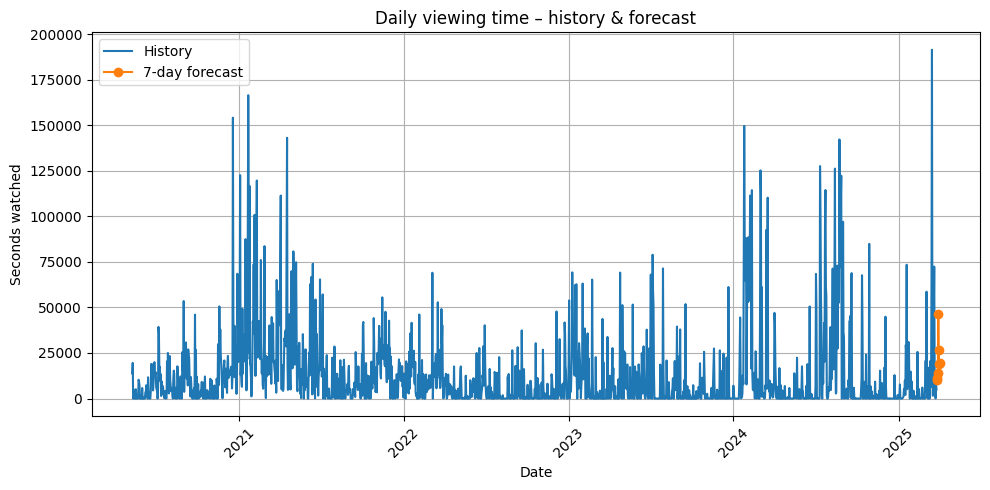

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

daily = (
    merged
    .groupby(merged['Start Time'].dt.date)['duration_sec']
    .sum()
    .reset_index()
    .rename(columns={'Start Time': 'date', 'duration_sec': 'total_sec'})
)
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').reset_index(drop=True)

full_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
daily = (
    daily.set_index('date')
         .reindex(full_range, fill_value=0)
         .rename_axis('date')
         .reset_index()
)

for lag in [1, 2, 3, 7, 14, 28]:
    daily[f'lag_{lag}'] = daily['total_sec'].shift(lag)

daily['dow']   = daily['date'].dt.dayofweek
daily['month'] = daily['date'].dt.month

daily = daily.dropna().reset_index(drop=True)

train = daily.iloc[:-30]
test  = daily.iloc[-30:]

X_train, y_train = train.drop(columns=['date', 'total_sec']), train['total_sec']
X_test,  y_test  = test.drop(columns=['date', 'total_sec']),  test['total_sec']

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.1f} sec")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse:.1f} sec")

print(f"R²   : {r2_score(y_test, y_pred):.3f}")

plt.figure(figsize=(10,5))
plt.plot(test['date'], y_test,      label='Actual',   marker='o')
plt.plot(test['date'], y_pred,      label='Predicted',marker='o')
plt.title('Daily viewing time – last 30 days')
plt.ylabel('Seconds watched')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

future_dates = pd.date_range(start=daily['date'].iloc[-1] + pd.Timedelta(days=1),
                             periods=7, freq='D')
history = daily.copy()

future_forecasts = []
for d in future_dates:
    feats = {
        f'lag_{lag}': history.loc[history['date'] == d - pd.Timedelta(days=lag),
                                 'total_sec'].values[0]
        for lag in [1,2,3,7,14,28]
    }
    feats['dow']   = d.dayofweek
    feats['month'] = d.month
    X_new = pd.DataFrame([feats])
    y_new = gbr.predict(X_new)[0]
    future_forecasts.append({'date': d, 'forecast_sec': y_new})
    history = pd.concat([history,
                         pd.DataFrame({'date':[d],'total_sec':[y_new],**feats})],
                        ignore_index=True)

future_df = pd.DataFrame(future_forecasts)

plt.figure(figsize=(10,5))
plt.plot(daily['date'], daily['total_sec'], label='History')
plt.plot(future_df['date'], future_df['forecast_sec'],
         label='7-day forecast', marker='o')
plt.title('Daily viewing time – history & forecast')
plt.ylabel('Seconds watched')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()